# Report 3 - Carl Moser

# Project Ideas

Some project ideas that I am interested in working on:

- Election prediction based on data mining from news sources or social media
- Expanding on my first report problem and doing some sort of word prediction

In [57]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
from scipy import stats
from scipy.special import binom

from thinkbayes2 import Pmf, Cdf, Suite, Joint, Beta, MakeBinomialPmf, \
EvalPoissonPmf, MakePoissonPmf, MakeMixture

import thinkplot

## The rain problem

You're about to get on a plane to Seattle. You want to know if you should bring an umbrella. You call 3 random friends of yours who live there and ask each independently if it's raining. Each of your friends has a 2/3 chance of telling you the truth and a 1/3 chance of messing with you by lying. All 3 friends tell you that "Yes" it is raining. What is the probability that it's actually raining in Seattle? 

In [3]:
seattle = Pmf({'raining': 9.4, 'not_raining': 90.6})
seattle['raining'] *= (2/3)**3
seattle['not_raining'] *= (1/3)**3
seattle.Normalize()
seattle.Print()

not_raining 0.5464414957780458
raining 0.4535585042219541


We can see that the chance that it is raining is about 45.4%

## Gluten allergy
From: [This study from 2015](http://onlinelibrary.wiley.com/doi/10.1111/apt.13372/full) showed that many subjects diagnosed with non-celiac gluten sensitivity (NCGS) were not able to distinguish gluten flour from non-gluten flour in a blind challenge.

Here is a description of the study:

>"We studied 35 non-CD subjects (31 females) that were on a gluten-free diet (GFD), in a double-blind challenge study. Participants were randomised to receive either gluten-containing ﬂour or gluten-free ﬂour for 10 days, followed by a 2-week washout period and were then crossed over. The main outcome measure was their ability to identify which ﬂour contained gluten.
>"The gluten-containing ﬂour was correctly identiﬁed by 12 participants (34%)..."
Since 12 out of 35 participants were able to identify the gluten flour, the authors conclude "Double-blind gluten challenge induces symptom recurrence in just one-third of patients fulﬁlling the clinical diagnostic criteria for non-coeliac gluten sensitivity."

This conclusion seems odd to me, because if none of the patients were sensitive to gluten, we would expect some of them to identify the gluten flour by chance.  So the results are consistent with the hypothesis that none of the subjects are actually gluten sensitive.

We can use a Bayesian approach to interpret the results more precisely.  But first we have to make some modeling decisions.

1. Of the 35 subjects, 12 identified the gluten flour based on resumption of symptoms while they were eating it.  Another 17 subjects wrongly identified the gluten-free flour based on their symptoms, and 6 subjects were unable to distinguish.  So each subject gave one of three responses.  To keep things simple I follow the authors of the study and lump together the second two groups; that is, I consider two groups: those who identified the gluten flour and those who did not.

2. I assume (1) people who are actually gluten sensitive have a 95% chance of correctly identifying gluten flour under the challenge conditions, and (2) subjects who are not gluten sensitive have only a 40% chance of identifying the gluten flour by chance (and a 60% chance of either choosing the other flour or failing to distinguish).

Using this model, estimate the number of study participants who are sensitive to gluten.  What is the most likely number?  What is the 95% credible interval?

In [4]:
correct = 12
incorrect = 17
indistinguishable = 6

t_correct = correct
t_incorrect = incorrect + indistinguishable
t_participants = t_correct + t_incorrect

In [5]:
class Gluten_study(Suite):
    def Likelihood(self, data, hypo):
        '''
        Computes the likelihood of the data
        
        data: correct, incorrect
            correct: the number of people who correctly guessed the flour
            incorrect: the number of people who incorrectly guessed or who could't decide
            participants: the number of people who participated in the survey
        hypo: The number of gluten sensitive people in the study
        '''
        correct, incorrect, participants = data
        gluten_sensitive = hypo
        non_gluten_sensitive = participants - gluten_sensitive

        pmf1 = MakeBinomialPmf(gluten_sensitive, 0.95)
        pmf2 = MakeBinomialPmf(non_gluten_sensitive, 0.4)
        
        pmf = pmf1 + pmf2
        return pmf[correct]

In [6]:
participants = range(0, t_participants+1)
gs = Gluten_study(participants)

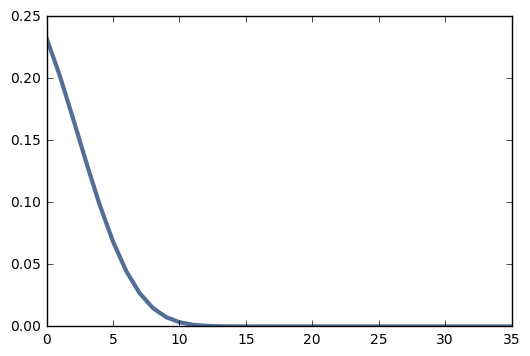

In [7]:
gs.Update((correct, incorrect, t_participants))
thinkplot.Pdf(gs)

In [8]:
print("Credible interval: ", gs.CredibleInterval(95))

Credible interval:  (0, 8)


## Bugfinder
From [John D. Cook](http://www.johndcook.com/blog/2010/07/13/lincoln-index/)

"Suppose you have a tester who finds 20 bugs in your program. You want to estimate how many bugs are really in the program. You know there are at least 20 bugs, and if you have supreme confidence in your tester, you may suppose there are around 20 bugs. But maybe your tester isn't very good. Maybe there are hundreds of bugs. How can you have any idea how many bugs there are? There’s no way to know with one tester. But if you have two testers, you can get a good idea, even if you don’t know how skilled the testers are.

Suppose two testers independently search for bugs. Let k1 be the number of errors the first tester finds and k2 the number of errors the second tester finds. Let c be the number of errors both testers find.  The Lincoln Index estimates the total number of errors as k1 k2 / c [I changed his notation to be consistent with mine]."

So if the first tester finds 20 bugs, the second finds 15, and they find 3 in common, we estimate that there are about 100 bugs.  What is the Bayesian estimate of the number of errors based on this data?

To start, we can define the number of bugs that each of the programmers found and how many of those were in common.

In [9]:
num_p1 = 20
num_p2 = 15
num_c = 3

Next, we can estimate the total number of bugs using the Lincoln index

(num_p1)(num_p2)/num_c

In [10]:
num_p1*num_p2/num_c

100.0

We see that the estimated number of bugs is about 100. We can take this problem further and do the Bayesian estimate of the number of errors. First, we can create a class that inherits from Suite and Joint. Then, we can define the Likelihood function. For this iteration of the likelihood function, I decided to just use stats.binom.pmf for now to see what the mean number of bugs looks like without the binomial coefficients.

In [11]:
class Bugfinder(Suite, Joint):
    def __init__(self, n, p1, p2):
        '''
        Makes a joint suite of parameters n, p1, p2

        n: possible number of bugs
        p1: the probability that programmer1 will find a bug
        p1: The probability that programmer 2 will find a bug
        '''
        trips = [(num, a1, a2)
                 for num in n
                 for a1 in p1 
                 for a2 in p2]
        
        Suite.__init__(self, trips)
        
    def Likelihood(self, data, hypo):
        '''
        k1, k2, c = data
        n, p1, p2 = hypo
        
        k1: The number of bugs that programmer 1 found
        k2: The number of bugs that programmer 2 found
        c:  The number of bugs that they found in common
        '''
        k1, k2, c = data
        n, p1, p2 = hypo
        
        like1 = stats.binom.pmf(k1, n, p1)
        like2 = stats.binom.pmf(k2, n, p2)
        
        return like1 * like2

We can then create arrays of the number of possible bugs, the probability that programmer 1 will find a bug, and the probability that programmer 2 will find a bug.

In [12]:
n = np.linspace(0, 400)
p1 = np.linspace(0,1,101)
p2 = np.linspace(0,1,101)

In [13]:
b = Bugfinder(n, p1, p2)
b.Update((20,15,3))

0.00010496169139310961

Mean number of bugs:  66.1450448034


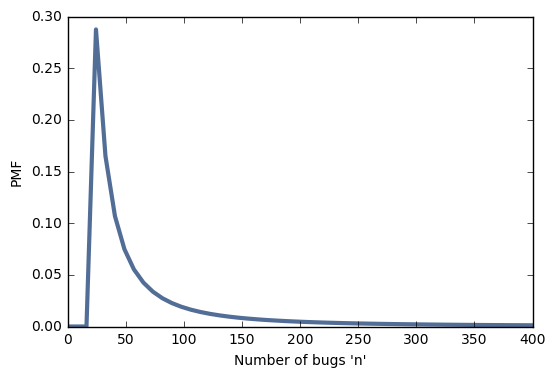

In [14]:
thinkplot.Pdf(b.Marginal(0))
thinkplot.Config(xlabel = "Number of bugs 'n'", ylabel = "PMF")
print("Mean number of bugs: ", b.Marginal(0).Mean())

Now we can go ahead and calculate the coefficients for like1 and like1 and put those in the likelihood function to take into account c.

In [15]:
class Bugfinder(Suite, Joint):
    def __init__(self, n, p1, p2):
        '''
        Makes a joint suite of parameters n, p1, p2

        n: possible number of bugs
        p1: the probability that programmer1 will find a bug
        p1: The probability that programmer 2 will find a bug
        '''
        trips = [(num, a1, a2)
                 for num in n
                 for a1 in p1 
                 for a2 in p2]
        
        Suite.__init__(self, trips)
        
    def Likelihood(self, data, hypo):
        '''
        k1, k2, c = data
        n, p1, p2 = hypo
        
        k1: The number of bugs that programmer 1 found
        k2: The number of bugs that programmer 2 found
        c:  The number of bugs that they found in common
        '''
        k1, k2, c = data
        n, p1, p2 = hypo
        
        like1 = stats.binom.pmf(k1, n, p1)
        like2 = stats.binom.pmf(k2, n, p2)
        like3 = stats.binom.pmf(c, n, p1*p2)
        
        return like1 * like2 * like3

In [16]:
b = Bugfinder(n, p1, p2)
b.Update((20,15,3))

7.6284745030314701e-06

Mean number of bugs:  97.8699074372


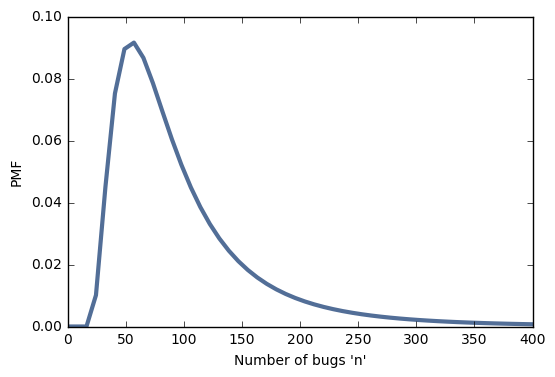

In [17]:
thinkplot.Pdf(b.Marginal(0))
thinkplot.Config(xlabel = "Number of bugs 'n'", ylabel = "PMF")
print("Mean number of bugs: ", b.Marginal(0).Mean())

From this, we can see that taking *c* into account improves the Bayesian estimate of the number of bugs. There is a difference of about 2 bugs between the Lincoln index and the Bayesian estimate.

## Original Problem

Data from http://www.dailymail.co.uk/sport/wimbledon/article-3143192/WIMBLEDON-2015-results-Men-s-women-s-singles-England-Club.html

This problem is building off of my report 2 original problem about the 2015 Wimbledon final. For that problem, I used previous win/loss statistics for each of the players. We can further analyze this problem using prediction with a Poisson process.

In 2015, Novak Djokovic beat Roger Federer in the Men's final of the Wimbledon. If they were to make it to the finals of another championship, what is the probability that Djokovic would win again? What is the chance that Federer would win?


To begin this problem, we can define the scores of Novak and Roger. Next, we can import all of the scores from the Wimbledon mens finals and calculate the mean and standard deviation.

In [18]:
import csv
novak = [7,7,6,10,6,6]
roger = [6,1,7,12,4,3]

scores = []
file = open('Scores.csv', 'r')
vals = csv.reader(file, delimiter = ',')
for val in vals:
    for v in val:
        scores.append(int(v))
file.close()

standard_dev = np.std(scores)
mean = np.mean(scores)

print(standard_dev)
print(mean)

2.01770203284
5.20552995392


In [19]:
def MakeGaussianPmf(mu, sigma, num_sigmas, n = 101):
    pmf = Pmf()
    low = mu - num_sigmas*sigma
    high = mu + num_sigmas*sigma
    
    for x in np.linspace(low, high, n):
        p = stats.norm.pdf(x, mu, sigma)
        pmf.Set(x, p)
    pmf.Normalize()
    return pmf

In [20]:
class Wimbledon(Suite):
    '''A class to represent the Wimbledon final'''
    def __init__(self, mu, sigma, n):
        '''
        init method that is called upon the denclaration of a new Wimbledon object
        
        mu: the mean of the scores
        sigma: the standard deviation of the scores
        
        '''
        pmf = MakeGaussianPmf(mu, sigma, n)
        Suite.__init__(self, pmf)
    
    def Likelihood(self, data, hypo):
        lam = hypo
        k = data
        like = EvalPoissonPmf(k, lam)
        return like

We can then create the suite objects and look at the distribution for both of them. We use a value of 2 for n because the low value cannot be negative.

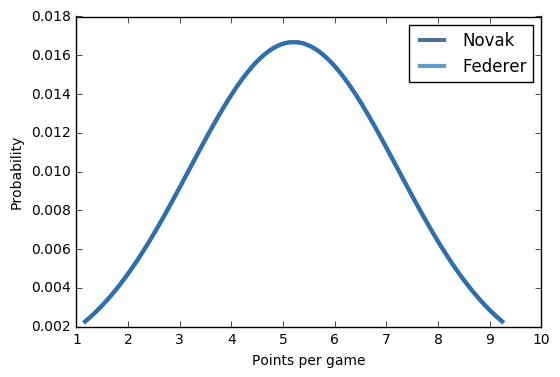

In [49]:
novak_suite = Wimbledon(mean, standard_dev, 2)
roger_suite = Wimbledon(mean, standard_dev, 2)

thinkplot.Pdf(novak_suite, label = "Novak")
thinkplot.Pdf(roger_suite, label = "Federer")
thinkplot.config(xlabel='Points per game', ylabel='Probability')

The scores for both of the players can be used to update the distributions. From the plot, we can see that the distribution for Novak is a little bit wider than for Federer. We can take the Maximum aposteori from the distributions and use them as the average shots per game.

Maximum aposteori probability for Novak 6.57756733625
Maximum aposteori probability for Roger 5.44765419786


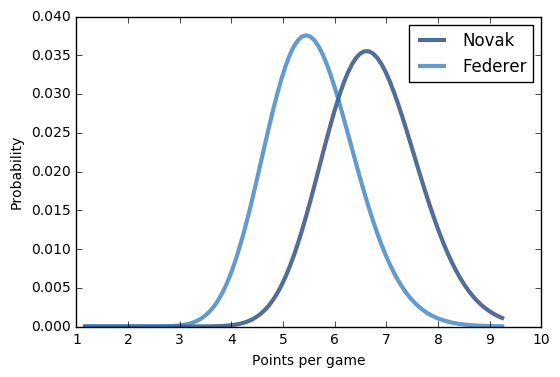

In [50]:
novak_suite.UpdateSet(novak)
roger_suite.UpdateSet(roger)

thinkplot.Pdf(novak_suite, label = "Novak")
thinkplot.Pdf(roger_suite, label = "Federer")
thinkplot.config(xlabel='Points per game', ylabel='Probability')

print("Maximum aposteori probability for Novak", novak_suite.MAP())
print("Maximum aposteori probability for Roger", roger_suite.MAP())

With this information, we can create a distribution of goals in a game. To do this, we can use a Poisson pmf with the MAP as lambda and 14 shots as the maximum because it would be very unlikely to score more than 14 points in a game.

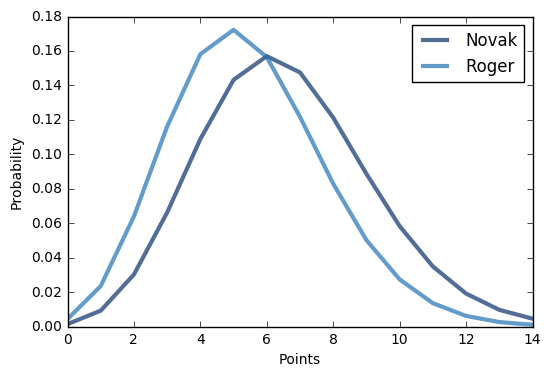

In [51]:
thinkplot.Pdf(MakePoissonPmf(novak_suite.MAP(), 14), label = "Novak")
thinkplot.Pdf(MakePoissonPmf(roger_suite.MAP(), 14), label = "Roger")
thinkplot.config(xlabel='Points', ylabel='Probability')

We can define a function that will take in a suite, make a pmf for every value of lambda, and put that in a pmf. This is called a metapmf (a pmf where the values are pmfs) and it can then be turned into a mixture.

In [55]:
def ShotPmf(wimbledom):
    '''
    This function takes in a suite and returns a mixture
    '''
    metapmf = Pmf()
    
    for lam, prob in wimbledom.Items():
        pmf = MakePoissonPmf(lam, 14)
        metapmf.Set(pmf, prob)
    
    mix = MakeMixture(metapmf)
    return mix

We can then make mixtures for both Novak and Roger and subtract them to get the difference between them. We can plot this to see what it looks like. The positive values are the chances that Novak will win. The negative values are the chances that Roger will win. Zero is the chance of a tie.

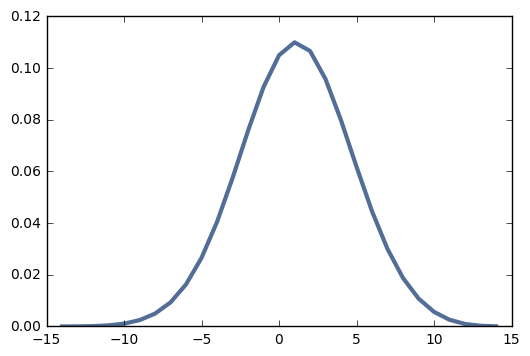

In [62]:
novak_dist = ShotPmf(novak_suite)
roger_dist = ShotPmf(roger_suite)

difference = novak_dist - roger_dist
thinkplot.Pdf(difference)

In [59]:
print("Novak wins again: ", difference.ProbGreater(0))
print("Roger wins: ", difference.ProbLess(0))
print("Tie: ", difference.Prob(0))

Novak wins again:  0.56734443091
Roger wins:  0.32767690465
Tie:  0.10497866444
